# Fitting Notebook
Here we fit the phi-distributions from the analysis notebook.
- Model selection - Cross validation score is used to demonstrate that fitting with the simple model is probably best.
- Fits of $\phi$ - Two methods of fitting the phi distributions are used, one single fit, and the bootstrap replica technique.
- MC study of fitting procedure - This has to wait, but I am going to use MC to throw a distribution in phi that follows the error bars of our measurement.
- Visualization
    - fit phi distributions 
    - bootstrap histograms
    - bootstrap score histograms
    - integrated fit results with errors

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

%matplotlib inline

plt.rc('font', family='serif')
plt.rc('font', size=18)

### Load Data
Here the data is loaded from the previous notebook called `analysis.ipynb`.  

In [2]:
data = pd.read_csv('results/phi-dist.csv')

In [3]:
data.columns

Index([u'axis', u'axis_bin', u'axis_max', u'axis_min', u'counts_neg',
       u'counts_pos', u'phi', u'phi_bin', u'stat', u'sys_0', u'value',
       u'global_index', u'sys_1', u'sys_10', u'sys_11', u'sys_2', u'sys_3',
       u'sys_4', u'sys_5', u'sys_6', u'sys_7', u'sys_8', u'sys_9',
       u'sys_total'],
      dtype='object')

### Setup Fitting 
Our model is defined below, it can be one of several different functions.  Fitting is done by minimizing the $\chi^2$.  Errors are estimated with the covariance matrix, or the bootstrap replica method.  Cross validation is defined, and the different models are evaluated.  

In [4]:
def chi2(y_true, y_pred, y_err):
    return np.sum((y_true-y_pred)**2/y_err**2)

In [5]:
class Model(object):

    def __init__(self):
        self.n_pars = 1
        self.pars   = np.zeros(shape=(self.n_pars, 1))
        self.bounds = np.array([[-1, 1],], dtype=np.float32)
        
    def get_initial_parameters(self):
        self.pars = np.random.uniform(-1.0, 1.0, size=(self.n_pars, 1))

    def evaluate(self, x):
        return 1.0

class SineModel(Model):

    def __init__(self):
        Model.__init__(self)
        self.n_pars = 1
        self.pars = np.zeros(shape=(self.n_pars, 1), dtype=np.float32)
        
    def evaluate(self, x):
        return self.pars[0]*np.sin( x*np.pi/180.0 )

class FullModel(Model):

    def __init__(self):
        Model.__init__(self)
        self.n_pars = 3
        self.pars = np.zeros(shape=(self.n_pars, 1), dtype=np.float32)
        self.bounds = np.array([[-1,1],
                                [-1,1],
                                [-1,1]],dtype=np.float32)
    def evaluate(self, x):
        return self.pars[0]*np.sin( x*np.pi/180.0 ) / (1 + self.pars[1]*np.cos(x*np.pi/180.0) + self.pars[2]*np.cos(2*x*np.pi/180.0))

def update_model(model, pars, x):
    model.pars = pars
    return model.evaluate(x)

In [6]:
from scipy.optimize import minimize

In [7]:
model = FullModel()
model.get_initial_parameters()

In [8]:
test_data = data.query('axis == "z" and axis_bin == 4')

In [9]:
from sklearn.utils import shuffle

def setup_dataframe(n_folds, x, y, y_err, shuf=False):
    
    if len(y) % n_folds != 0:
        print('Data (%d) is not divisible into %d folds.' % (len(y), n_folds))
        return 
    
    x = x.transpose()
    y = y.transpose()
    y_err = y_err.transpose()
    
    d  = {'x':x, 'y':y, 'y_err':y_err}
    df = pd.DataFrame(data=d)
    
    if shuf is True:
        df = shuffle(df)

    chunk_size = int(len(y)/n_folds) 
    
    a = np.arange(0,n_folds)
    df['chunk'] = np.repeat(a,chunk_size)
    return df

def cross_validate(n_folds, model, df):

    validation_scores = []
    parameters = []
    for i in range(n_folds):
        res = minimize(fun=lambda p: np.average((df.query('chunk != %d' % i).y - update_model(model, p, df.query('chunk != %d' % i).x))**2/df.query('chunk != %d' % i).y_err**2), 
                    x0=model.pars, bounds=model.bounds)
                                
        y_pred = update_model(model, res.x, df.query('chunk == %d' % i).x)
        validation_scores.append(np.average((df.query('chunk == %d' % i).y-y_pred)**2/df.query('chunk == %d' % i).y_err**2))
        parameters.append(res.x)
        
    return np.array(validation_scores), parameters

In [10]:
models = {}

models['basic'] = SineModel()
models['full'] = FullModel()
models['half'] = FullModel()
models['half'].bounds = np.array([[-1,1],[-1,1],[-0.0001,0.0001]], dtype=np.float32)

models['full_bounded'] = FullModel()
models['full_bounded'].bounds = np.array([[-1,1],[-0.1,0.1],[-0.1,0.1]], dtype=np.float32)
                                          
for m in models.values():
    m.get_initial_parameters()
    
model_names_dict = {}
model_names_dict['full'] = 'sin, cos, cos2'
model_names_dict['full_bounded'] = 'sin, cos, cos2 (bounded)'
model_names_dict['half'] = 'sin, cos'
model_names_dict['basic'] = 'sin'

### Cross Validation
Compare different models.

In [11]:
CHUNKS = 12
df_chunked = setup_dataframe(CHUNKS, test_data.phi, test_data.value, np.sqrt(test_data.sys_total**2 + test_data.stat**2), shuf=False)

In [12]:
cv_scores = {}
cv_pars = {}

for name, m in models.iteritems():
    print('Fitting %s' % name)
    cv_scores[name], cv_pars[name] = cross_validate(CHUNKS, m, df_chunked)

Fitting full_bounded
Fitting half
Fitting full
Fitting basic


In [13]:
for k,v in cv_scores.iteritems():
    print('Model %s, Score %.2f' % (k, np.average(v)))

Model basic, Score 2.13
Model full_bounded, Score 2.13
Model full, Score 3.48
Model half, Score 2.22


In [14]:
!mkdir image/

mkdir: image/: File exists


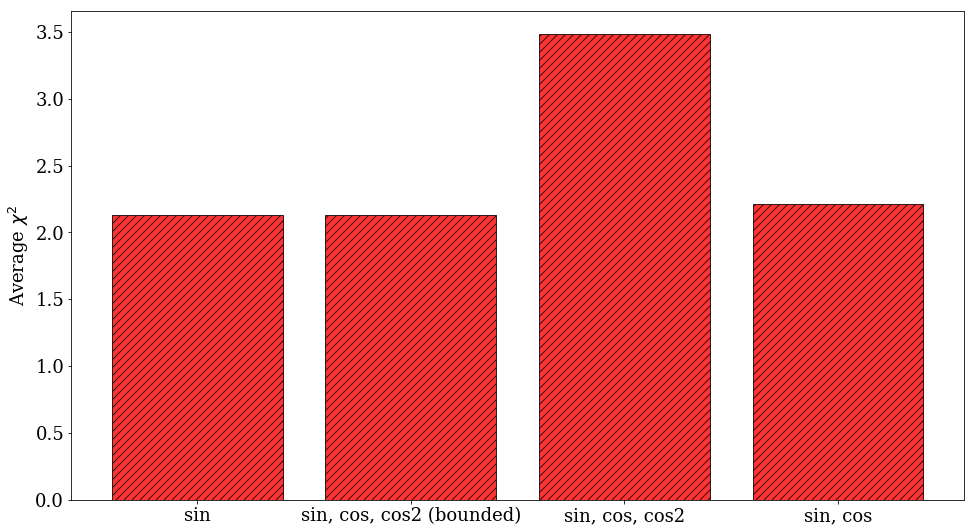

In [15]:
h = [np.average(xx) for xx in cv_scores.values()]
e = [np.std(xx) for xx in cv_scores.values()]
n = [model_names_dict[x] for x in cv_scores.keys()]

plt.figure(figsize=(16,9))
plt.bar(np.arange(len(cv_scores.keys())), height=h,
       color='red', edgecolor='black', hatch='///', alpha=0.8)
plt.xticks(np.arange(len(cv_scores.keys())), n)
plt.ylabel('Average $\chi^2$')
plt.savefig('image/cv-score-models.pdf', bbox_inches='tight')

In [16]:
#plt.figure(figsize=(8,6))
#plt.errorbar(x=np.arange(len(cv_scores.keys())), y=h, yerr=e,
#            linestyle='', marker='o')
#plt.xticks(np.arange(len(cv_scores.keys())), cv_scores.keys())

/Users/dmriser/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


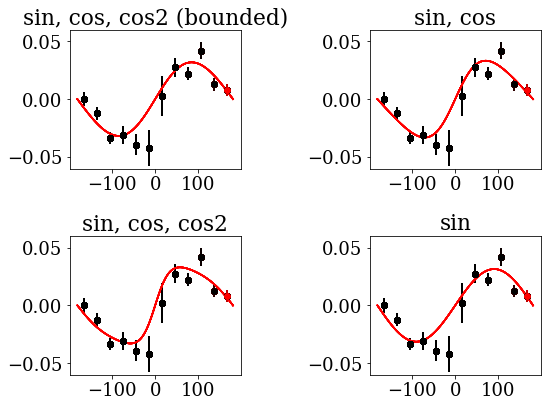

In [17]:


n_col = 2
n_row = np.ceil((len(cv_pars.keys())-1)/n_col)+1
plt.figure(figsize=(n_col*4, n_row*3))

chunks = len(np.unique(df_chunked.chunk))

x = np.linspace(-180,180,100)

for chunk in range(chunks):
    
    train = df_chunked.query('chunk != %d' % chunk)
    test  = df_chunked.query('chunk == %d' % chunk)
    index = 1
    
    for name, model in models.iteritems():
        plt.subplot(n_row, n_col, index)
        plt.errorbar(train.x, train.y, train.y_err, linestyle='', marker='o', color='black')
        plt.errorbar(test.x, test.y, test.y_err, linestyle='', marker='o', color='red')
        plt.ylim([-0.06, 0.06])
    
        y = [update_model(model, cv_pars[name][1], xi) for xi in x]
        plt.plot(x, y, color='red')
        index += 1
    
        plt.title(model_names_dict[name])
    
        plt.tight_layout()
        plt.savefig('image/cv-demo-models-%d.pdf' % chunk, bbox_inches='tight')

### Toy Dataset Testing 
This toy dataset is used to study what we can actually extract.  The section should be moved to another part of the notebook.

In [18]:
def generate_toy_data(df, model):
    d = df.copy(deep=True)
    d.value = model.evaluate(d.phi) + np.random.normal(loc=0.0, scale=np.sqrt(d.stat**2 + d.sys_total**2))
    return d

In [19]:
#models['full'].pars = [0.05, 0.02, -0.02]
models['basic'].pars = [0.05]
mc = generate_toy_data(test_data, models['basic'])

Text(0.5,1,u'Toy Monte Carlo Data')

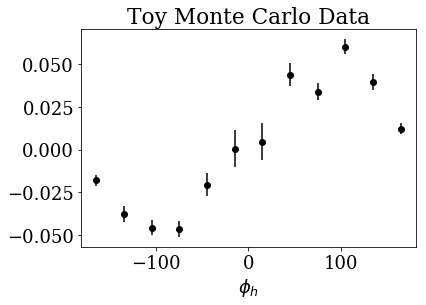

In [20]:
plt.errorbar(x=mc.phi, y=mc.value, yerr=mc.stat, color='black', 
            linestyle='', marker='o')
plt.xlabel('$\phi_h$')
plt.title('Toy Monte Carlo Data')

In [21]:
rmc = minimize(fun=lambda x: chi2(mc.value, update_model(models['full'], x, mc.phi), np.sqrt(mc.stat**2 + mc.sys_total**2)), 
             x0=models['full'].pars,
            bounds=models['full'].bounds)

In [22]:
rmc

      fun: 11.044787886093273
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -5.23314725e-04,  -5.86197757e-06,  -1.86517468e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 96
      nit: 19
   status: 0
  success: True
        x: array([ 0.04564551,  0.24659139,  0.02301183])

In [23]:
def single_fit(model, data):
    model.get_initial_parameters()
    res = minimize(fun=lambda x: chi2(data.value, update_model(model, x, data.phi), np.sqrt(data.stat**2 + data.sys_total**2)), 
             x0=model.pars, bounds=model.bounds)

    identity = np.identity(len(model.pars))
    err = np.sqrt(np.array(np.matrix(res.hess_inv * identity).diagonal()))
    #err.reshape(model.n_pars,1)
    
    return res.x, err[0]

In [24]:
def create_replica(y, y_err):
    y_rep = [np.random.normal(yp,np.fabs(yp_err)) for yp,yp_err in zip(y,y_err)]
    return np.array(y_rep)

In [25]:
import sys

def bootstrap_fit(model, data, n_replicas=100):

    results = []
    scores = []
    
    for irep in range(n_replicas):
        d = data.copy(deep=True)
        rep = create_replica(d.value, np.sqrt(d.stat**2 + d.sys_total**2)) 
        d['value'] = rep   
        pars,errs = single_fit(model, d)
        results.append(pars)
        scores.append(chi2(d.value, update_model(model, pars, d.phi), np.sqrt(d.stat**2 + d.sys_total**2)))
        
        if irep%10 is 0:
            sys.stdout.write('\rProcessing replica (%d/%d)' % (irep, n_replicas))
            sys.stdout.flush()
            
    return np.array(results), np.array(scores)

In [26]:
boot,boot_score = bootstrap_fit(models['half'], test_data, 400)

Processing replica (390/400)

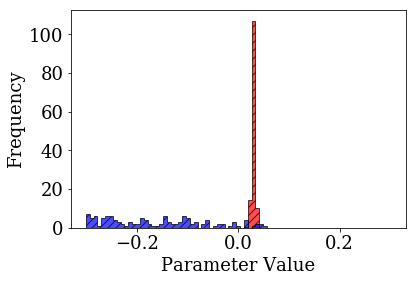

In [27]:
hb = np.linspace(-0.3, 0.3, 80)
plt.hist(boot[:,0], bins=hb, normed=True, histtype='stepfilled',
        color='red', edgecolor='black', alpha=0.7, hatch='///');
plt.hist(boot[:,1], bins=hb, normed=True, histtype='stepfilled',
        color='blue', edgecolor='black', alpha=0.7, hatch='///');
plt.xlabel('Parameter Value')
plt.ylabel('Frequency')
plt.savefig('image/bootstrap-demo-pdf.pdf', bbox_inches='tight')

In [28]:
np.average(boot[:,0]), np.std(boot[:,0])

(0.030213854098577277, 0.0029698687602864485)

In [29]:
np.average(boot[:,1]), np.std(boot[:,1])

(-0.38610448392541236, 0.19482160551412478)

In [30]:
def fit_dataset(data, model, fit_type='single'):
    '''
    inputs
    ------
    
    data: a dataframe which contains the output of the analysis notebook, phi-distributions 
    
    model: a model object
    
    '''
    
    result = {}
    result['axis'] = []
    result['axis_bin'] = []
    
    params = {}
    params['axis'] = []
    params['axis_bin'] = []
    params['value'] = []
    
    for p in range(model.n_pars):
        result['par_%d' % p] = []
        result['err_%d' % p] = []
        
    for axis in np.unique(data.axis):
        dsub = data.query('axis == "%s"' % axis)
        
        for bin in np.unique(dsub.axis_bin):
            d = dsub.query('axis_bin == %d' % bin)
            
            print(' Fitting %s,%d' % (axis, bin))
            
            # get fit to data
            
            if fit_type is 'single':
                pars,errs = single_fit(model, d)
                params['value'].append(pars)
                
            elif fit_type is 'replica':    
                boot, boots = bootstrap_fit(model, d, n_replicas=200)
                params['value'].append(boot)
                
                pars = []
                errs = []
                for ipar in range(model.n_pars):
                    pars.append(np.average(boot[:,ipar]))
                    errs.append(np.std(boot[:,ipar]))
            
            result['axis'].append(axis)
            result['axis_bin'].append(bin)
            
            params['axis'].append(axis)
            params['axis_bin'].append(bin)
            
            for p in range(model.n_pars):
                result['par_%d' % p].append(pars[p])
                result['err_%d' % p].append(errs[p])
            
    return pd.DataFrame(result), params

In [31]:
models_to_run = ['basic', 'full_bounded']
estimators    = ['single', 'replica']

fitres = {}
params = {}


for est in estimators:
    fitres[est] = {}
    params[est] = {}
  
    for m in models_to_run:
        print('Fitting for %s, %s' % (est, m))
        
        fitres[est][m], params[est][m] = fit_dataset(data, models[m], est)

Fitting for single, basic
 Fitting pt,0
 Fitting pt,1
 Fitting pt,2
 Fitting pt,3
 Fitting pt,4
 Fitting pt,5
 Fitting q2,0
 Fitting q2,1
 Fitting q2,2
 Fitting q2,3
 Fitting q2,4
 Fitting q2,5
 Fitting x,0
 Fitting x,1
 Fitting x,2
 Fitting x,3
 Fitting x,4
 Fitting x,5
 Fitting z,0
 Fitting z,1
 Fitting z,2
 Fitting z,3
 Fitting z,4
 Fitting z,5
Fitting for single, full_bounded
 Fitting pt,0
 Fitting pt,1
 Fitting pt,2
 Fitting pt,3
 Fitting pt,4
 Fitting pt,5
 Fitting q2,0
 Fitting q2,1
 Fitting q2,2
 Fitting q2,3
 Fitting q2,4
 Fitting q2,5
 Fitting x,0
 Fitting x,1
 Fitting x,2
 Fitting x,3
 Fitting x,4
 Fitting x,5
 Fitting z,0
 Fitting z,1
 Fitting z,2
 Fitting z,3
 Fitting z,4
 Fitting z,5
Fitting for replica, basic
 Fitting pt,0
Processing replica (190/200) Fitting pt,1
Processing replica (190/200) Fitting pt,2
Processing replica (190/200) Fitting pt,3
Processing replica (190/200) Fitting pt,4
Processing replica (190/200) Fitting pt,5
Processing replica (190/200) Fitting q2,0


In [32]:
import scipy.stats as stats

Text(0.5,1,u'Scores from Bootstraps')

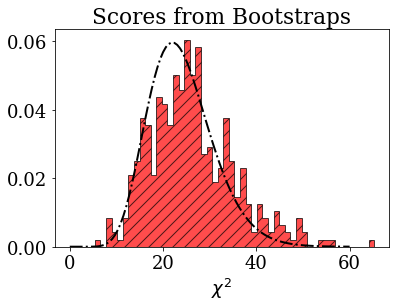

In [33]:
plt.hist(boot_score, bins=50, normed=True, histtype='stepfilled',
        color='red', edgecolor='black', hatch='//', alpha=0.7);

x = np.linspace(0, 60, 100)
plt.plot(x, stats.chi2.pdf(x,24), linestyle='-.', color='black', linewidth=2.0)

plt.xlabel('$\chi^2$')
plt.title('Scores from Bootstraps')

In [34]:
def plot_results(results, axis):
    
    d      = results.query('axis == "%s"' % axis)
    n_bins = len(np.unique(d.axis_bin))
    n_col  = 3
    n_row  = np.ceil(n_bins/n_col)+1

    # these are uniform width
    phi_width = np.repeat(float(360.0/len(np.unique(d.phi_bin))), len(np.unique(d.phi_bin)))
    phi_edges = np.linspace(-180,180,len(np.unique(d.phi_bin)))
    plt.figure(figsize=(4*n_col, 3*n_row))
    
    for index in range(n_bins):
        dsub = d.query('axis_bin == %d' % index)
        plt.subplot(n_row, n_col, index+1)
        plt.errorbar(x=dsub.phi, y=dsub.value, yerr=dsub.stat, 
                    linestyle='', marker='o', color='black')
        
        if 'sys_total' in dsub.columns:
            plt.bar(phi_edges, height=dsub.sys_total, width=phi_width, bottom=0.0, 
                    edgecolor='red', color='yellow', alpha=0.65, hatch='///', 
                    label='systematic error', align='edge')
            
        plt.axhline(0.0, linestyle='--',
                    linewidth=1, color='black', alpha=0.7)
        
        plt.xlim([-180,180])
        plt.ylim([-0.15, 0.15])
        
    plt.tight_layout()

In [35]:
results = {}


for est in estimators:
    results[est] = {}
  
    for m in models_to_run:
        results[est][m] = pd.merge(data, fitres[est][m], on=['axis', 'axis_bin'])

In [36]:
results['replica']['basic'].to_csv('results/phi-dist-fit.csv', index=False)

### Plot for Bootstraps Demo

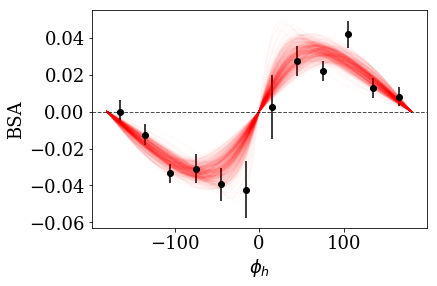

In [37]:
phi = np.linspace(-180,180,100)
for pars in boot:
    plt.plot(phi, update_model(models['full'], pars, phi), color='red', alpha=0.02)

plt.errorbar(test_data.phi, test_data.value, np.sqrt(test_data.sys_total**2 + test_data.stat**2),
        linestyle='', marker='o', color='black')
plt.ylabel('BSA')
plt.xlabel('$\phi_h$')
plt.axhline(0.0, color='black', linestyle='--', alpha=0.7, linewidth=1)
plt.savefig('image/bootstrap-demo.pdf', bbox_inches='tight')

In [57]:
def plot_summary(results):

    latex = {}
    latex['x'] = '$x$'
    latex['z'] = '$z$'
    latex['pt'] = '$P_T$'
    latex['q2'] = '$Q^2$'
    
    axes = np.unique(results.axis)
    
    n_col = 2
    n_row = 1 + np.ceil(len(axes)/n_col)
    plt.figure(figsize=(4*n_col, 3*n_row))
    
    for index, axis in enumerate(axes):
        plt.subplot(n_row, n_col, index+1)
        d = results.query('axis == "%s"' % axis)
        
        plt.errorbar(d.axis_min + 0.5*(d.axis_max-d.axis_min), d.par_0, d.err_0,
                    linestyle='', marker='o', color='black')
        plt.xlabel(latex[axis])
        plt.ylabel('$A_{LU}^{\sin\phi}$')
        plt.ylim([-0.02, 0.08])
        plt.axhline(0.0, color='black', alpha=0.7, linestyle='--', linewidth=1)
        
    plt.tight_layout()
    
def plot_multiple_summary(result1, result2, label1, label2):
     
    latex = {}
    latex['x'] = '$x$'
    latex['z'] = '$z$'
    latex['pt'] = '$P_T$'
    latex['q2'] = '$Q^2$'
    
    axes = np.unique(result1.axis)
    
    n_col = 2
    n_row = 1 + np.ceil(len(axes)/n_col)
    plt.figure(figsize=(5*n_col, 3*n_row))
    
    for index, axis in enumerate(axes):
        plt.subplot(n_row, n_col, index+1)
        d1 = result1.query('axis == "%s"' % axis)
        d2 = result2.query('axis == "%s"' % axis)
        
        plt.errorbar(d1.axis_min + 0.5*(d1.axis_max-d1.axis_min), d1.par_0, d1.err_0,
                    linestyle='', marker='.', color='black', label=label1)
        plt.errorbar(d2.axis_min + 0.5*(d2.axis_max-d2.axis_min), d2.par_0, d2.err_0,
                    linestyle='', marker='.', color='red', label=label2)
        
        plt.xlabel(latex[axis])
        plt.ylabel('$A_{LU}^{\sin\phi}$')
        plt.ylim([-0.02, 0.08])
        plt.axhline(0.0, color='black', alpha=0.7, linestyle='--', linewidth=1)
        plt.legend()
        
    plt.tight_layout()

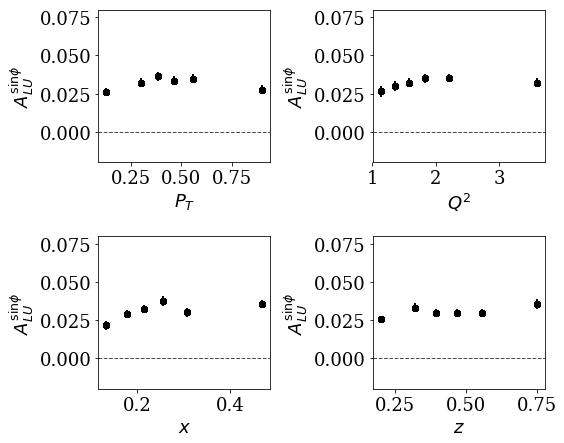

In [58]:
plot_summary(results['replica']['basic'])
plt.savefig('image/summary.pdf', bbox_inches='tight')

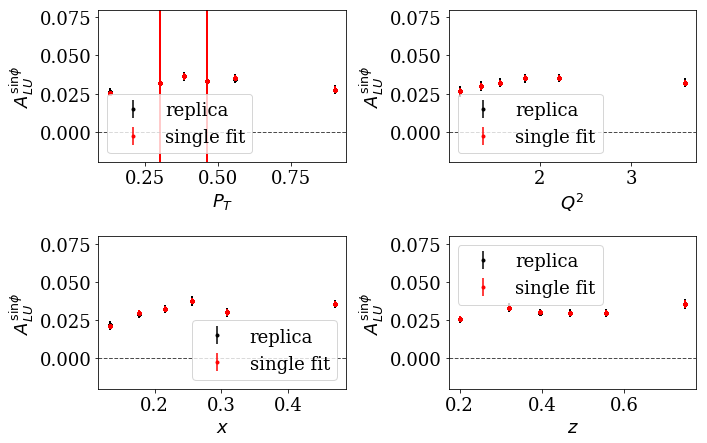

In [59]:
plot_multiple_summary(results['replica']['basic'], results['single']['basic'], 'replica', 'single fit')
plt.savefig('image/summary-compare.pdf', bbox_inches='tight')

In [41]:
def plot_axis(result, model, axis):
        
    d      = result.query('axis == "%s"' % axis)
    n_bins = len(np.unique(d.axis_bin))
    n_col  = 3
    n_row  = np.ceil(n_bins/n_col)+1

    # these are uniform width
    phi_width = np.repeat(float(360.0/len(np.unique(d.phi_bin))), len(np.unique(d.phi_bin)))
    phi_edges = np.linspace(-180,180,len(np.unique(d.phi_bin)))
    plt.figure(figsize=(4*n_col, 3*n_row))
    
    phi = np.linspace(-180,180,100)
    
    for index in range(n_bins):
        dsub = d.query('axis_bin == %d' % index)
        plt.subplot(n_row, n_col, index+1)
        plt.errorbar(x=dsub.phi, y=dsub.value, yerr=dsub.stat, 
                    linestyle='', marker='o', color='black')
        
        if 'sys_total' in dsub.columns:
            plt.bar(phi_edges, height=dsub.sys_total, width=phi_width, bottom=0.0, 
                    edgecolor='black', color='red', alpha=0.65, hatch='///', 
                    label='systematic error', align='edge')
        
        y  = update_model(model, np.unique(dsub.par_0), phi)
        dy = update_model(model, np.unique(dsub.err_0), phi)
        
        plt.plot(phi, y, color='black', linestyle='-.', linewidth=1)
        plt.fill_between(phi, y1=y-dy, y2=y+dy, color='gray', alpha=0.5)
        
        plt.axhline(0.0, linestyle='--',
                    linewidth=1, color='black', alpha=0.7)
        
        plt.xlim([-180,180])
        plt.ylim([-0.08, 0.08])
        plt.ylabel('BSA')
        plt.xlabel('$\phi_h$')
        
    plt.tight_layout()

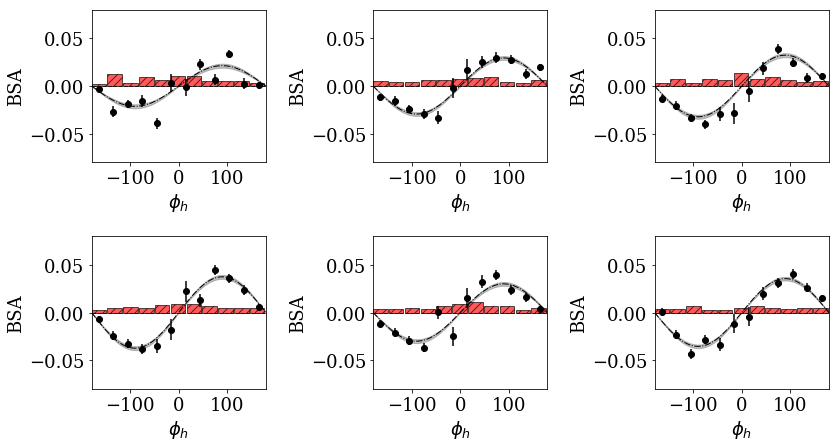

In [42]:
plot_axis(results['single']['basic'], models['basic'], 'x')
plt.savefig('image/phi-dist-fit-x.pdf', bbox_inches='tight')

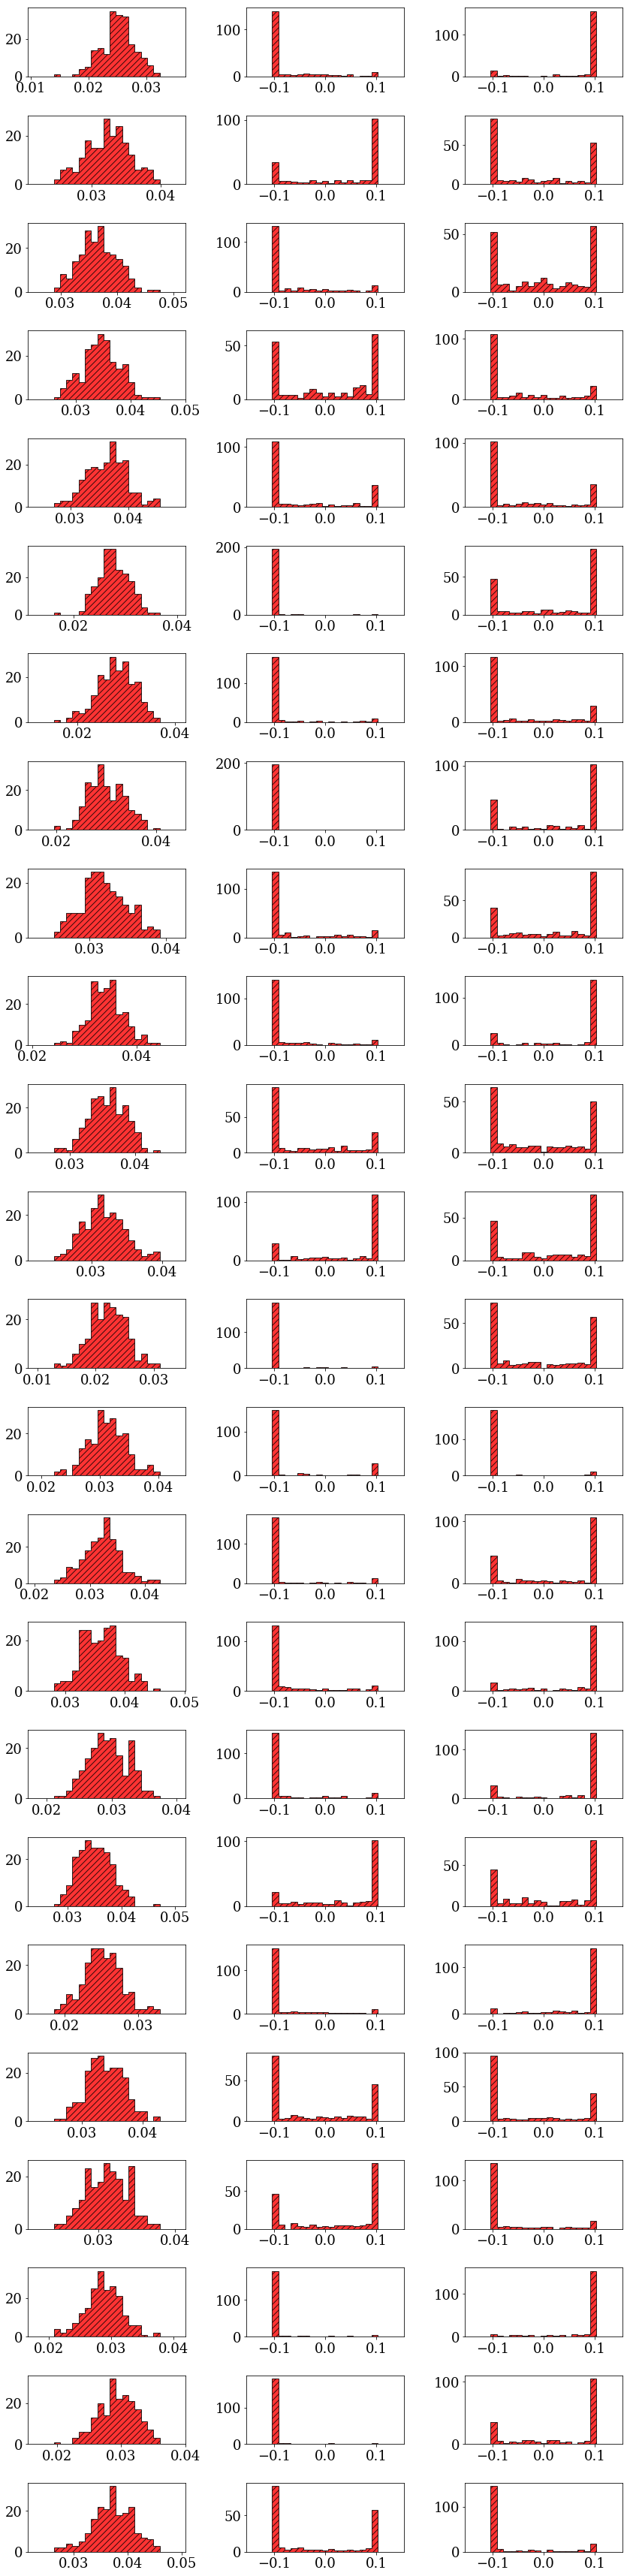

In [56]:
binner = lambda x: np.linspace(np.min(x)-0.2*(np.max(x)-np.min(x)), np.max(x)+0.2*(np.max(x)-np.min(x)), 24)

n_cols = 3
n_rows = len(params['replica']['full_bounded']['value'])

plt.figure(figsize=(12,2*n_rows))

for i in range(n_rows):
    plt.subplot(n_rows,3,1+i*n_cols)
    plt.hist(params['replica']['full_bounded']['value'][i][:,0], 
             bins=binner(params['replica']['full_bounded']['value'][i][:,0]),
            histtype='stepfilled', color='red', edgecolor='black', hatch='///', alpha=0.8);

    plt.subplot(n_rows,3,2+i*n_cols)
    plt.hist(params['replica']['full_bounded']['value'][i][:,1],
             bins=binner(params['replica']['full_bounded']['value'][i][:,1]),
            histtype='stepfilled', color='red', edgecolor='black', hatch='///', alpha=0.8);

    plt.subplot(n_rows,3,3+i*n_cols)
    plt.hist(params['replica']['full_bounded']['value'][i][:,2],          
             bins=binner(params['replica']['full_bounded']['value'][i][:,1]),
            histtype='stepfilled', color='red', edgecolor='black', hatch='///', alpha=0.8);

plt.tight_layout()